In [254]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./"), '..')))


import inspect
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import plot_settings as plot_settings
import sympy as sp

In [255]:
# UTILS FUNCTIONS

# This function returns the number of
# parameters of a given lambda function
def get_parameters_count(function):
    return len(inspect.signature(function).parameters)

def get_t_parameters(expression):
    # Extracting t parameters as a sorted set
    return sorted(
        set(re.findall(r't\d+', expression)), 
        key=lambda x: int(x[1:])
    )

# This function can extract a lambda function
# from a given string expression
def parse_lambda(expression):
    # Extracting t parameters
    t_vars = get_t_parameters(expression)

    # Creating parameters string with x in the beginning
    lambda_params = ['x'] + t_vars    
    string_params = ', '.join(lambda_params)
    
    string_lambda = f"lambda {string_params} : {expression}"

    # Replacing exponential expressions to make them compatible with Python syntax
    replacements = [
        ("e","np.e"),
        ("^","**"),
        ("log","np.log"),
    ]

    for replacement in replacements:
        string_lambda = string_lambda.replace(*replacement)
        
    print(string_lambda)
    lambda_func = eval(string_lambda)
    return lambda_func

def extract_A_matrix(expression, x):
    no_spaces_expression = expression.replace(" ", "")
    splitted_terms = no_spaces_expression.split("+")
    t_params = get_t_parameters(expression)

    base_terms = []

    for term in splitted_terms:
        for t in t_params:
            term = term.replace(t, "")
            term = term.replace("*", "")
        
        if(term == ''):
            term = "1"
            
        base_terms.append(parse_lambda(term))

    A = []
    for x_value in x:
        a = [lambda_term(x_value) for lambda_term in base_terms]
        A.append(a)
    A = np.array(A)

    return A

In [256]:
# FITTING FUNCTIONS

# Chi-square
def chi2(y_obs, y_pred, y_err):
    return np.sum(((y_obs - y_pred) / y_err) ** 2)

def analytic_least_squared(expression, x, y, y_err):
    # Computing V
    V = np.eye(len(y_err)) * y_err
    V_inv = np.linalg.inv(V)

    # Computing A and
    A = extract_A_matrix(expression, x)
    
    # Computing B matrix
    B = np.linalg.inv(A.T @ V_inv @ A) @ A.T @ V_inv

    # Computing optimal parameters
    opt_params = B@y

    return parse_lambda(expression), opt_params, [0]*A.shape[1]
    



# Fitting function with least squared method
# by minimizing chi-square function
def numeric_least_squared(expression, x, y, y_err, ):
    func = parse_lambda(expression)
    parameters_count = get_parameters_count(func) - 1 # Excluding x
    initial_guess = [1] * parameters_count

    chi2_lambda = lambda params: chi2(y, func(x, *params), y_err)
    
    # Minimizing
    result = minimize(
        chi2_lambda, 
        initial_guess, 
        method="BFGS"
    )
    
    # Extracting error
    opt_parameters = result.x 
    cov_matrix = result.hess_inv
    errors = np.sqrt(np.diag(cov_matrix))
    
    return func, opt_parameters, errors

In [257]:

# Reading data
data_df = pd.read_csv('data.txt', sep='\t')

# Hypothesized functions
# The content is a list of tuple
# (Expression, Analitically)
# Expression is the given expression
# Analitically can be:
#   - True if it can be solved analitically
#   - False if it must be solved numerically
expressions = [
    ("t0 * x^t1", False),
    ("t0 + t1 * x + t2 * x^2", True),
    ("t0 + t1 * x + t2 * e^x", True),
]

In [258]:
# Splitting data
x = data_df["x"].values
y = data_df["y_mean"].values
y_err = data_df["std"].values

results = []

# Fitting functions with LS
for expression, analitically in expressions:
    if analitically:             
        extracted_function, opt_params, error = analytic_least_squared(expression, x, y, y_err)                                                                       
    else:
        extracted_function, opt_params, error = numeric_least_squared(expression, x, y, y_err)

    
    # Adding results
    results.append((expression, extracted_function, opt_params, error))


lambda x, t0, t1 : t0 * x**t1
lambda x : 1
lambda x : x
lambda x : x**2
lambda x, t0, t1, t2 : t0 + t1 * x + t2 * x**2
lambda x : 1
lambda x : x
lambda x : np.e**x
lambda x, t0, t1, t2 : t0 + t1 * x + t2 * np.e**x



Results:
----------------------------------------
y = t0 * x^t1
Optimal parameters: 
	t0 = 1.777 
	t1 = 1.787 
Errors: 
	sigma_t0 = 0.030 
	sigma_t1 = 0.013 
Chi-square: 30.293362569078457
Pearson: 4.327623224154065
----------------------------------------
y = t0 + t1 * x + t2 * x^2
Optimal parameters: 
	t0 = 4.201 
	t1 = -2.229 
	t2 = 1.585 
Errors: 
	sigma_t0 = 0.000 
	sigma_t1 = 0.000 
	sigma_t2 = 0.000 
Chi-square: 9.264714623076465
Pearson: 1.5441191038460775
----------------------------------------
y = t0 + t1 * x + t2 * e^x
Optimal parameters: 
	t0 = 1.097 
	t1 = 2.230 
	t2 = 0.175 
Errors: 
	sigma_t0 = 0.000 
	sigma_t1 = 0.000 
	sigma_t2 = 0.000 
Chi-square: 4.74352865405369
Pearson: 0.7905881090089483


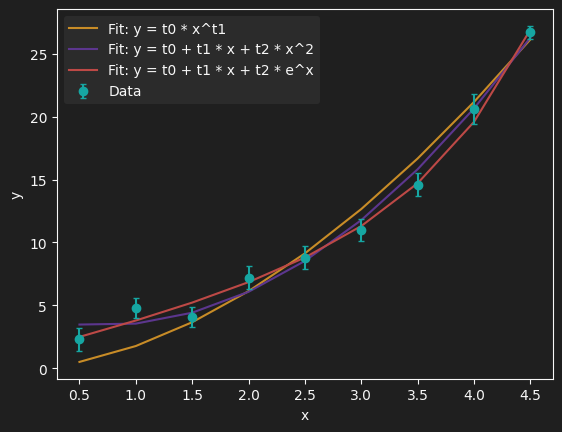

In [259]:
# Showing results
print("\nResults:")

fig, ax= plot_settings.figure_ax()
pearson_test = []

# Plotting fitted functions
for color_index, result in enumerate(results):
    expression = result[0]
    function = result[1]
    opt_params = result[2]
    error = result[3]

    string_opt_params = ""
    for i, value in enumerate(opt_params):
        string_opt_params += f"\n\tt{i} = {value:.3f} "

    string_errors = ""
    for i, value in enumerate(error):
        string_errors += f"\n\tsigma_t{i} = {value:.3f} "

    y_pred = function(x, *opt_params)

    # Pearson chi2 test
    chi2_value = chi2(y, y_pred, y_err)
    deg_freedom = len(y) - (get_parameters_count(function) - 1)
    p_value = chi2_value / deg_freedom
    
    pearson_test.append((expression,p_value))
    print("----------------------------------------")
    print(f"y = {expression}")
    print(f"Optimal parameters: {string_opt_params}")
    print(f"Errors: {string_errors}")
    print(f"Chi-square: {chi2_value}")
    print(f"Pearson: {p_value}")
    ax.plot(x, function(x, *opt_params), label=f'Fit: y = {expression}', c=plot_settings.color(color_index))
    

# Plotting data
ax.errorbar(x, y, yerr=y_err, fmt='o', label='Data', capsize=2, c= "#16A6A2")

plot_settings.set_plot_theme(ax)


In [260]:
# Pearson test

# Selecting best fitting function
# getting the one that has the pearson
# test value nearest to 1
best_index = -1
last_distance = -1
for index, test in enumerate(pearson_test):
    p_value = test[1] 
    quadratic_distance_from_one = ((p_value - 1) ** 2)
    if quadratic_distance_from_one < last_distance or best_index == -1:
        best_index = index
        last_distance = quadratic_distance_from_one

print("Best fitting function")
print(f"y = {pearson_test[best_index][0]}")
    


Best fitting function
y = t0 + t1 * x + t2 * e^x
